# MAME Loader

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

RAW_DATA_PATH = 'input/data/raw'

MINITRAIN_PATH = 'input/data/train/'
MINIVAL_PATH = 'input/data/val/'
MINITEST_PATH = 'input/data/test/'

META_PATH = 'input/metadata/'
IMG_SIZE = 256.
N_CHANNELS = 3

# Load Data

There is a toy dataset much smaller than the real one. This can be pretty good to configure the whole load-train-predict pipeline before facing a much bigger problem.

## Label Distribution Set

In [2]:
df_labels = pd.read_csv(os.path.join(META_PATH, 'MAMe_labels.csv'), header=None, names=['id', 'label'])
print("There are {} unique labels.".format(len(df_labels.label.unique())))
df_labels

There are 29 unique labels.


,id,label
0,0,Albumen photograph
1,1,Bronze
2,2,Ceramic
3,3,Clay
4,4,Engraving
5,5,Etching
6,6,Faience
7,7,Glass
8,8,Gold
9,9,Graphite


There are 37407 images in the dataset.
There are 37407 images in the TOY dataset.


,Image file,Medium,Museum,Museum-based instance ID,Subset,Width,Height,Product size,Aspect ratio
0,436018.jpg,Oil on canvas,Metropolitan Museum of Art,29.100.60,train,3144.0,3840.0,12072960.0,0.8187
1,11779.jpg,Oil on canvas,Metropolitan Museum of Art,1982.373,train,1707.0,2136.0,3646152.0,0.7992
2,19022.jpg,Oil on canvas,Metropolitan Museum of Art,2006.418,train,2845.0,3811.0,10842295.0,0.7465
3,435883.jpg,Oil on canvas,Metropolitan Museum of Art,61.101.3,train,3811.0,2916.0,11112876.0,1.3069
4,10481.jpg,Oil on canvas,Metropolitan Museum of Art,09.95,train,3811.0,2099.0,7999289.0,1.8156


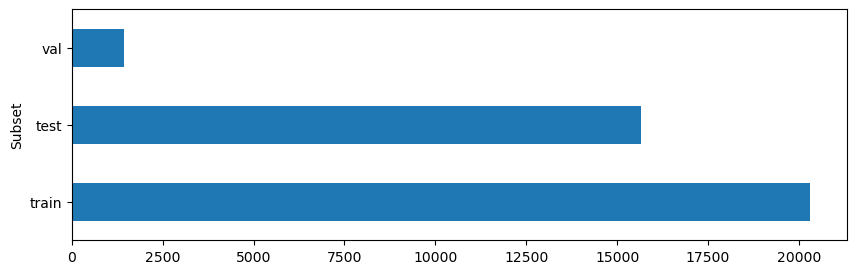

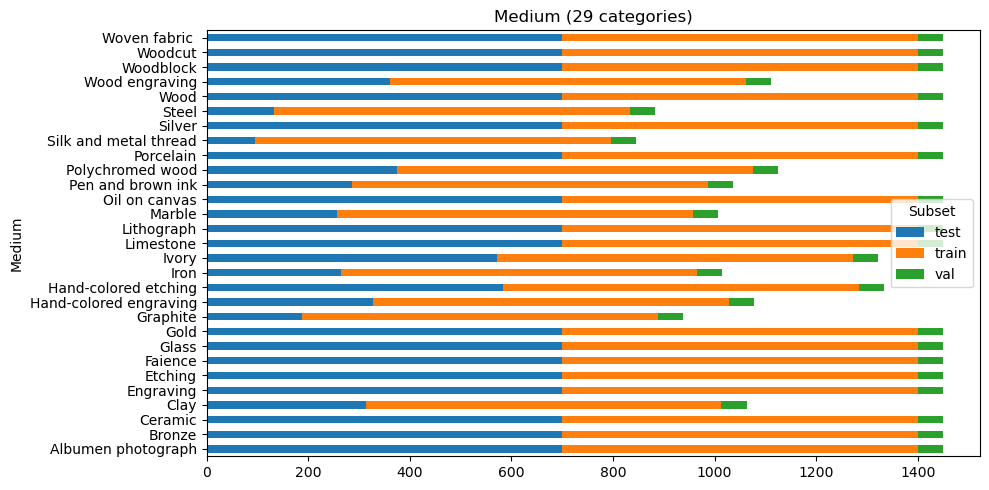

In [3]:
df_info_toy = pd.read_csv(META_PATH + 'MAMe_dataset.csv')
print(f"There are {len(os.listdir(RAW_DATA_PATH))} images in the dataset.")
print(f"There are {len(df_info_toy)} images in the TOY dataset.")

plt.figure(figsize=(10, 3))
df_info_toy.Subset.value_counts().plot.barh()

df_info_toy.groupby(['Medium', 'Subset']).size().unstack().plot.barh(stacked=True, figsize=(10, 5))
plt.title(f'Medium ({df_info_toy.Medium.nunique()} categories)')
plt.tight_layout()

df_info_toy.head()

In [4]:
df_load_data = df_info_toy.merge(df_labels, right_on='label', left_on='Medium')[['Image file', 'Subset', 'id']]
df_load_data.head()

,Image file,Subset,id
0,436018.jpg,train,17
1,11779.jpg,train,17
2,19022.jpg,train,17
3,435883.jpg,train,17
4,10481.jpg,train,17


In [5]:
arr_train = []
arr_test = []
arr_val = []

# add tqdm to see progress bar
for i, row in df_load_data.iterrows():
    img = plt.imread(os.path.join(RAW_DATA_PATH, row['Image file']))
    if row['Subset'] == 'train':
        arr_train.append(img)
    elif row['Subset'] == 'test':
        arr_test.append(img)
    elif row['Subset'] == 'val':
        arr_val.append(img)

arr_train = np.array(arr_train)
y_train = df_load_data[df_load_data['Subset'] == 'train']['id'].values

arr_test = np.array(arr_test)
y_test = df_load_data[df_load_data['Subset'] == 'test']['id'].values

arr_val = np.array(arr_val)
y_val = df_load_data[df_load_data['Subset'] == 'val']['id'].values

print(f"Train shape: {arr_train.shape}")
print(f"Test shape: {arr_test.shape}")
print(f"Val shape: {arr_val.shape}")

Train shape: (19600, 256, 256, 3)
Test shape: (14957, 256, 256, 3)
Val shape: (1400, 256, 256, 3)


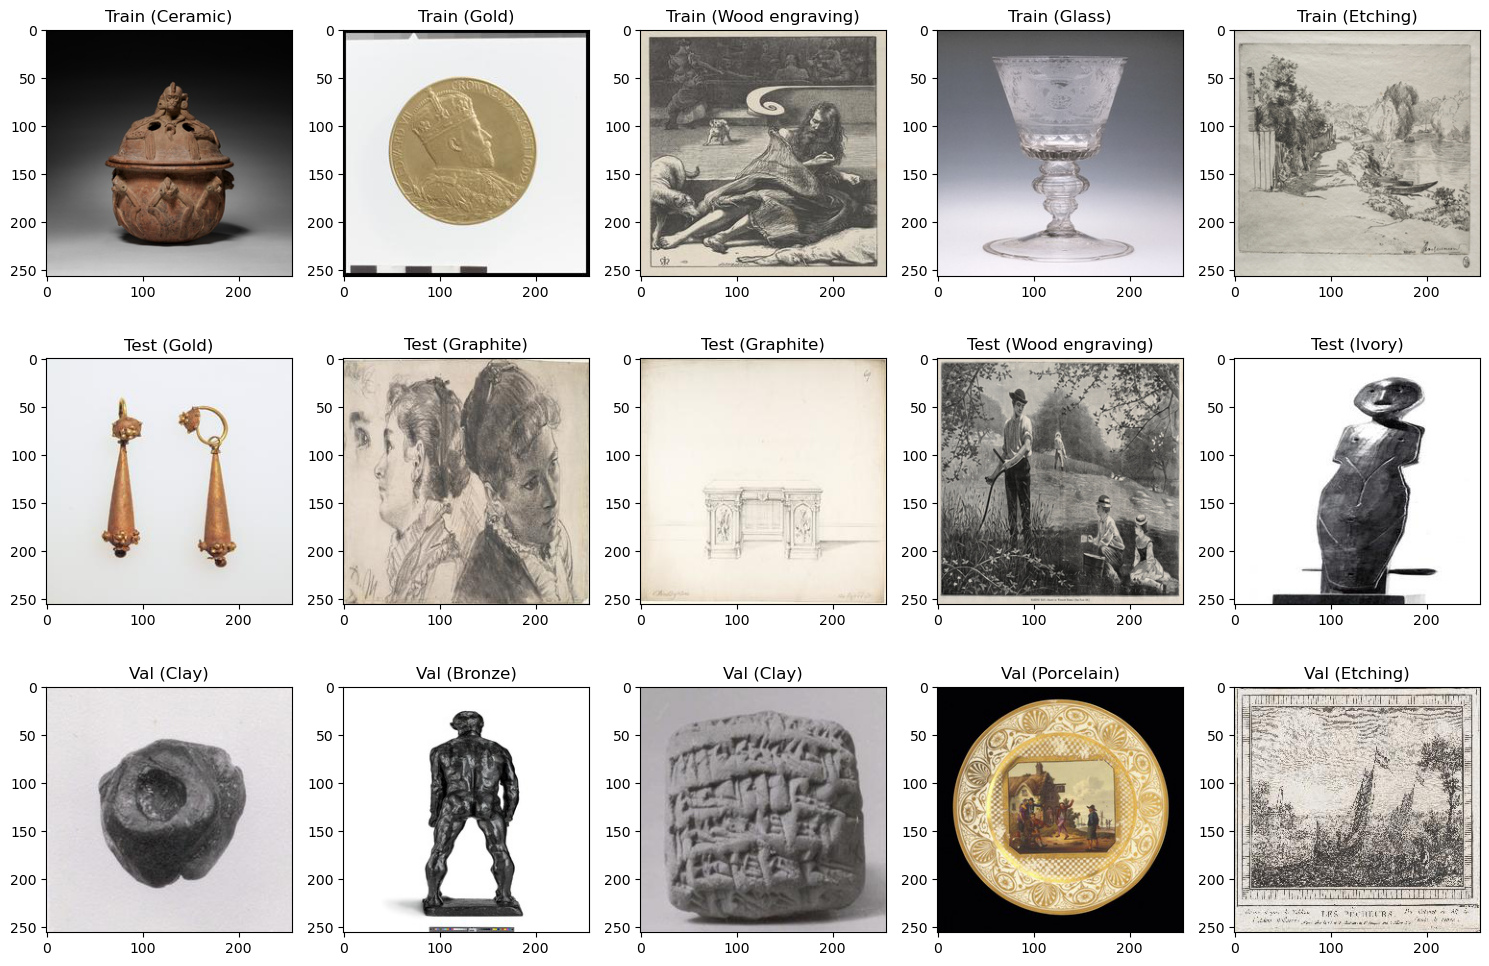

In [6]:
d_labels = df_labels.to_dict()['label']

rand_idx_train = np.random.randint(0, len(arr_train), 5)
rand_idx_test = np.random.randint(0, len(arr_test), 5)
rand_idx_val = np.random.randint(0, len(arr_val), 5)

fig, axes = plt.subplots(3, 5, figsize=(15, 10))
for i, idx in enumerate(rand_idx_train):
    axes[0, i].imshow(arr_train[idx])
    axes[0, i].set_title(f"Train ({d_labels[y_train[idx]]})")

for i, idx in enumerate(rand_idx_test):
    axes[1, i].imshow(arr_test[idx])
    label = df_info_toy[df_info_toy['Subset'] == 'test'].iloc[idx].loc['Medium']
    axes[1, i].set_title(f"Test ({d_labels[y_test[idx]]})")

for i, idx in enumerate(rand_idx_val):
    axes[2, i].imshow(arr_val[idx])
    label = df_info_toy[df_info_toy['Subset'] == 'val'].iloc[idx].loc['Medium']
    axes[2, i].set_title(f"Val ({d_labels[y_val[idx]]})")

plt.tight_layout()

In [ ]:
# write files to disk .npz
np.savez_compressed(MINITRAIN_PATH + 'train.npz', **{'X': arr_train, 'y': y_train})
np.savez_compressed(MINIVAL_PATH + 'val.npz', **{'X': arr_val, 'y': y_val})
np.savez_compressed(MINITEST_PATH + 'test.npz', **{'X': arr_test, 'y': y_test})